## 1. Data collection and preprocessing #
Our scope of study is on American economy indicators and COVID new cases from 2020/01 to 2021/12.

In [ ]:
# Prerequisite to run this program on Colab.
# Remove this cell otherwise.
from google.colab import drive
drive.mount('/content/gdrive')

# Replace the link with your own file path.
%cd /content/gdrive/My\ Drive/HKBU/EDA/COMP3115/src

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1Ywe5jCwvzFrD9KR7N2H8CsnRkMiEcf9w/COMP3115/src


In [ ]:
import pandas as pd

df_fred_gdp = pd.read_csv('../data/FRED/GDP.csv') # GDP GROWTH RATE
df_fred_uer = pd.read_csv('../data/FRED/UNRATE.csv') # UNEMPLOMENT RATE
df_fred_ipi = pd.read_csv('../data/FRED/INDPRO.csv') # IND. PROD. RATE
df_fred_fed = pd.read_csv('../data/FRED/FEDFUNDS.csv') # INTEREST RATE
df_fred_cpi = pd.read_csv('../data/FRED/CPIAUCSL.csv') # INFLATION RATE

# Raw GDP data is quarterly.
df_fred_gdp.head()

,DATE,GDP
0,2019/10/1,21706.532
1,2020/1/1,21538.032
2,2020/4/1,19636.731
3,2020/7/1,21362.428
4,2020/10/1,21704.706


In [ ]:
def fill_date(date, x):
    if x in [1, 2]:
        date = date.split('/')
        month = str(int(date[1]) + x)
        return '/'.join([date[0], month, date[2]])

def fill_gdp(gdp_c, gdp_n, x):
    if x in [1, 2]:
        return gdp_c + (gdp_n - gdp_c) * (x/3)

def fill_growth(pct_p, pct_c):
    return (pct_c/pct_p - 1) * 100

for i in range(df_fred_gdp.shape[0] - 1):
    # Get dates between quarters.
    qd1 = df_fred_gdp['DATE'][i]
    qd2 = fill_date(qd1, 1)
    qd3 = fill_date(qd1, 2)
    # Estimate monthly GDP.
    gdp_l = df_fred_gdp['GDP'][i]
    gdp_4 = df_fred_gdp['GDP'][i + 1]
    gdp_2 = fill_gdp(gdp_l, gdp_4, 1)
    gdp_3 = fill_gdp(gdp_l, gdp_4, 2)
    # Insert them all.
    df_fred_gdp.loc[i + 0.1] = qd2, gdp_2
    df_fred_gdp.loc[i + 0.2] = qd3, gdp_3

df_fred_gdp = df_fred_gdp.sort_index().reset_index(drop = True)

# Recalculate monthly GDP growth.
monthly_gdp_growth = [0]
for i in range(1, df_fred_gdp.shape[0]):
    last_year = df_fred_gdp['GDP'][i - 1]
    this_year = df_fred_gdp['GDP'][i]
    monthly_gdp_growth.append(fill_growth(last_year, this_year))

df_fred_gdp['GDPNOW'] = monthly_gdp_growth

## 2. Feature engineering #

In [ ]:
# Filter dates between 2019/12/1 and 2021/12/1.
for i in range(df_fred_gdp.shape[0]):
    date = df_fred_gdp['DATE'][i].split('/')
    year = int(date[0])
    month = int(date[1])
    if year not in [2020, 2021] and month != 12:
        df_fred_gdp = df_fred_gdp.drop(i, axis = 0)

df_fred_gdp = df_fred_gdp.reset_index(drop = True)
df_fred_gdp.head()

,DATE,GDP,GDPNOW
0,2019/12/1,21594.198667,-0.259426
1,2020/1/1,21538.032000,-0.260101
2,2020/2/1,20904.265000,-2.942548
3,2020/3/1,20270.498000,-3.031759
4,2020/4/1,19636.731000,-3.126549


In [ ]:
df_econ = df_fred_gdp.copy()
df_econ = df_econ.join(df_fred_uer.iloc[:, [1]])
df_econ = df_econ.join(df_fred_ipi.iloc[:, [1]])
df_econ = df_econ.join(df_fred_fed.iloc[:, [1]])
df_econ = df_econ.join(df_fred_cpi.iloc[:, [1]])
df_econ.head()

,DATE,GDP,GDPNOW,UNRATE,INDPRO,FEDFUNDS,CPIAUCSL
0,2019/12/1,21594.198667,-0.259426,3.6,101.8840,1.55,258.616
1,2020/1/1,21538.032000,-0.260101,3.5,101.3768,1.55,259.037
2,2020/2/1,20904.265000,-2.942548,3.5,101.6330,1.58,259.248
3,2020/3/1,20270.498000,-3.031759,4.4,97.6672,0.65,258.124
4,2020/4/1,19636.731000,-3.126549,14.7,84.5979,0.05,256.092


In [ ]:
df_econ.to_csv('../data/econ.csv')
df_covid = pd.read_csv('../data/us_covid.csv')
df_covid = df_covid[['date', 'new_cases']]

In [ ]:
# Filter dates before 2021.
for i in range(df_covid.shape[0]):
    date = df_covid['date'][i].split('-')
    year = int(date[2])
    if year > 2021:
        df_covid = df_covid.drop(i, axis = 0)

# Raw COVID data is daily.
df_covid.tail()

,date,new_cases
726,27-12-2021,115824.0
727,28-12-2021,211284.0
728,29-12-2021,464495.0
729,30-12-2021,389514.0
730,31-12-2021,474309.0


In [ ]:
# Record end of each month.
end = []
for i in range(df_covid.shape[0] - 1):
    this_month = df_covid['date'][i].split('-')[1]
    next_month = df_covid['date'][i + 1].split('-')[1]
    if this_month != next_month:
        end.append(df_covid['date'][i])
end.append(df_covid['date'][df_covid.shape[0] - 1])

# Sum to get monthly new cases.
monthly_new_cases = []
for i in range(df_covid.shape[0]):
    date = df_covid['date'][i]
    day = date.split('-')[0]

    if day == '01':
        sum = 0
    
    sum += df_covid['new_cases'][i]

    if date in end:
        monthly_new_cases.append(sum)

# Filter beginning of each month.
for i in range(df_covid.shape[0]):
    date = df_covid['date'][i]
    day = date.split('-')[0]
    if day != '01':
        df_covid = df_covid.drop(i, axis = 0)

df_covid['new_cases'] = monthly_new_cases
df_covid = df_covid.reset_index(drop = True)
df_covid.tail()

,date,new_cases
19,01-08-2021,4114589.0
20,01-09-2021,4185050.0
21,01-10-2021,2660463.0
22,01-11-2021,2444998.0
23,01-12-2021,5449603.0


In [ ]:
df = df_econ.iloc[1:, [0]]
df.index -= 1

df['COVID'] = df_covid.iloc[:, [1]]

df_lag_econ = df_econ.iloc[:-1, 2:]
df_adv_econ = df_econ.iloc[1:, 2:]
df_adv_econ.index -= 1

df = df.join(df_lag_econ)
df = df.rename(columns = {'GDPNOW': 'LAG_GDPNOW',
                          'UNRATE': 'LAG_UNRATE',
                          'INDPRO': 'LAG_INDPRO',
                          'FEDFUNDS': 'LAG_FEDFUNDS',
                          'CPIAUCSL': 'LAG_CPI'})

df = df.join(df_adv_econ - df_lag_econ)
df = df.rename(columns = {'GDPNOW': 'DIR_GDPNOW',
                          'UNRATE': 'DIR_UNRATE',
                          'INDPRO': 'DIR_INDPRO',
                          'FEDFUNDS': 'DIR_FEDFUNDS',
                          'CPIAUCSL': 'DIR_CPI'})

df.tail(12)

,DATE,COVID,LAG_GDPNOW,LAG_UNRATE,LAG_INDPRO,LAG_FEDFUNDS,LAG_CPI,DIR_GDPNOW,DIR_UNRATE,DIR_INDPRO,DIR_FEDFUNDS,DIR_CPI
12,2021/1/1,6285448.0,0.926832,6.7,97.9754,0.09,262.035,-0.008511,-0.4,0.8082,0.00,0.615
13,2021/2/1,2467058.0,0.918320,6.3,98.7836,0.09,262.650,0.176790,-0.1,-3.4092,-0.01,0.988
14,2021/3/1,1776581.0,1.095111,6.2,95.3744,0.08,263.638,-0.011863,-0.1,2.7607,-0.01,1.276
15,2021/4/1,1832202.0,1.083248,6.1,98.1351,0.07,264.914,-0.011609,0.0,0.1535,0.00,1.756
16,2021/5/1,981676.0,1.071639,6.1,98.2886,0.07,266.670,-0.343435,-0.3,0.8622,-0.01,1.774
17,2021/6/1,385721.0,0.728204,5.8,99.1508,0.06,268.444,-0.005264,0.1,0.3588,0.02,2.115
18,2021/7/1,1373312.0,0.722939,5.9,99.5096,0.08,270.559,-0.005189,-0.5,0.6135,0.02,1.205
19,2021/8/1,4114589.0,0.717751,5.4,100.1231,0.10,271.764,0.412733,-0.2,0.0024,-0.01,1.106
20,2021/9/1,4185050.0,1.130484,5.2,100.1255,0.09,272.870,-0.012637,-0.4,-1.0641,-0.01,1.158
21,2021/10/1,2660463.0,1.117847,4.8,99.0614,0.08,274.028,-0.012358,-0.3,1.2431,0.00,2.494


In [ ]:
def classify(x):
    if x < 0:
        return 0 # decrease
    return 1 # increase

for i in range(df.shape[0]):
    for j in df.columns[7:]:
        df.at[i, j] = classify(df[j][i])

df.to_csv('../output/scope_3.csv')
df.tail(12)

,DATE,COVID,LAG_GDPNOW,LAG_UNRATE,LAG_INDPRO,LAG_FEDFUNDS,LAG_CPI,DIR_GDPNOW,DIR_UNRATE,DIR_INDPRO,DIR_FEDFUNDS,DIR_CPI
12,2021/1/1,6285448.0,0.926832,6.7,97.9754,0.09,262.035,0.0,0.0,1.0,1.0,1.0
13,2021/2/1,2467058.0,0.918320,6.3,98.7836,0.09,262.650,1.0,0.0,0.0,0.0,1.0
14,2021/3/1,1776581.0,1.095111,6.2,95.3744,0.08,263.638,0.0,0.0,1.0,0.0,1.0
15,2021/4/1,1832202.0,1.083248,6.1,98.1351,0.07,264.914,0.0,1.0,1.0,1.0,1.0
16,2021/5/1,981676.0,1.071639,6.1,98.2886,0.07,266.670,0.0,0.0,1.0,0.0,1.0
17,2021/6/1,385721.0,0.728204,5.8,99.1508,0.06,268.444,0.0,1.0,1.0,1.0,1.0
18,2021/7/1,1373312.0,0.722939,5.9,99.5096,0.08,270.559,0.0,0.0,1.0,1.0,1.0
19,2021/8/1,4114589.0,0.717751,5.4,100.1231,0.10,271.764,1.0,0.0,1.0,0.0,1.0
20,2021/9/1,4185050.0,1.130484,5.2,100.1255,0.09,272.870,0.0,0.0,0.0,0.0,1.0
21,2021/10/1,2660463.0,1.117847,4.8,99.0614,0.08,274.028,0.0,0.0,1.0,1.0,1.0


In [ ]:
from sklearn import preprocessing

# min-max normalization
df_scale_min_max = preprocessing.MinMaxScaler().fit_transform(df.loc[:, df.columns == 'COVID'])
df_scale_min_max = pd.DataFrame(df_scale_min_max, columns = ['COVID'])

df['COVID'] = df_scale_min_max
df.tail(12)

,DATE,COVID,LAG_GDPNOW,LAG_UNRATE,LAG_INDPRO,LAG_FEDFUNDS,LAG_CPI,DIR_GDPNOW,DIR_UNRATE,DIR_INDPRO,DIR_FEDFUNDS,DIR_CPI
12,2021/1/1,1.000000,0.926832,6.7,97.9754,0.09,262.035,0.0,0.0,1.0,1.0,1.0
13,2021/2/1,0.392502,0.918320,6.3,98.7836,0.09,262.650,1.0,0.0,0.0,0.0,1.0
14,2021/3/1,0.282649,1.095111,6.2,95.3744,0.08,263.638,0.0,0.0,1.0,0.0,1.0
15,2021/4/1,0.291498,1.083248,6.1,98.1351,0.07,264.914,0.0,1.0,1.0,1.0,1.0
16,2021/5/1,0.156181,1.071639,6.1,98.2886,0.07,266.670,0.0,0.0,1.0,0.0,1.0
17,2021/6/1,0.061366,0.728204,5.8,99.1508,0.06,268.444,0.0,1.0,1.0,1.0,1.0
18,2021/7/1,0.218490,0.722939,5.9,99.5096,0.08,270.559,0.0,0.0,1.0,1.0,1.0
19,2021/8/1,0.654621,0.717751,5.4,100.1231,0.10,271.764,1.0,0.0,1.0,0.0,1.0
20,2021/9/1,0.665831,1.130484,5.2,100.1255,0.09,272.870,0.0,0.0,0.0,0.0,1.0
21,2021/10/1,0.423273,1.117847,4.8,99.0614,0.08,274.028,0.0,0.0,1.0,1.0,1.0


## 3. Model building #

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Separate features and labels.
X, y = df[df.columns[1:7]], df[df.columns[7:]].values

# Split x and y into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4)
print('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 18
Test cases: 6


In [ ]:
import numpy as np

# Train a logistic regression model for each x and y.
reg = 0.01

predictions = []
for i in range(len(y[0])):
    X_feat = X_train.iloc[:, [0, i + 1]]
    y_feat = y_train[:, i]
    model = LogisticRegression(C = 1/reg, solver = "liblinear").fit(X_feat, y_feat)
    pred = model.predict(X_test.iloc[:, [0, i + 1]])
    print('Label Col. Name: ', df.columns[7:][i])
    print('Predicted labels:', pred)
    print('Actual labels:   ', y_test[:, i])
    predictions.append(pred)

Label Col. Name:  DIR_GDPNOW
Predicted labels: [0. 0. 0. 1. 0. 0.]
Actual labels:    [0. 0. 0. 0. 0. 1.]
Label Col. Name:  DIR_UNRATE
Predicted labels: [1. 0. 1. 1. 0. 0.]
Actual labels:    [0. 0. 0. 1. 0. 0.]
Label Col. Name:  DIR_INDPRO
Predicted labels: [1. 1. 1. 1. 0. 1.]
Actual labels:    [1. 1. 0. 0. 1. 1.]
Label Col. Name:  DIR_FEDFUNDS
Predicted labels: [1. 1. 0. 1. 1. 1.]
Actual labels:    [1. 1. 1. 0. 1. 1.]
Label Col. Name:  DIR_CPI
Predicted labels: [1. 1. 1. 1. 1. 1.]
Actual labels:    [1. 1. 1. 0. 1. 1.]


## 4. Model evaluation and interpretation #

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def eval(test, pred):
    # Print the confusion matrix.
    matrix = confusion_matrix(test, pred)
    print(matrix)

    tp = matrix[1][1]
    fp = matrix[0][1]
    fn = matrix[1][0]
    tn = matrix[0][0]

    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)

    print('TP =', tp, 'FP =', fp, '\nFN =', fn, 'TN =', tn)
    print('Sensitivity =', round(sens, 3))
    print('Specificity =', round(spec, 3))
    print('Precision =', round(prec, 3))
    print()

In [ ]:
titles = ['GDP Growth Nowcasted by GDPNow',
          'Unemployment Rate',
          'Industrial Production',
          'Federal Funds Effective Rate',
          'Consumer Price Index']

for i in range(len(y[0])):
    print(titles[i])
    eval(y_test[:, i], predictions[i])

GDP Growth Nowcasted by GDPNow
[[4 1]
 [1 0]]
TP = 0 FP = 1 
FN = 1 TN = 4
Sensitivity = 0.0
Specificity = 0.8
Precision = 0.0

Unemployment Rate
[[3 2]
 [0 1]]
TP = 1 FP = 2 
FN = 0 TN = 3
Sensitivity = 1.0
Specificity = 0.6
Precision = 0.333

Industrial Production
[[0 2]
 [1 3]]
TP = 3 FP = 2 
FN = 1 TN = 0
Sensitivity = 0.75
Specificity = 0.0
Precision = 0.6

Federal Funds Effective Rate
[[0 1]
 [1 4]]
TP = 4 FP = 1 
FN = 1 TN = 0
Sensitivity = 0.8
Specificity = 0.0
Precision = 0.8

Consumer Price Index
[[0 1]
 [0 5]]
TP = 5 FP = 1 
FN = 0 TN = 0
Sensitivity = 1.0
Specificity = 0.0
Precision = 0.833



## 5. Visualization #
Key steps:
1. Show each feature's change by date with line chart.
2. Show each feature's distribution differed by label.
3. Show each feature's cluster differed by label.

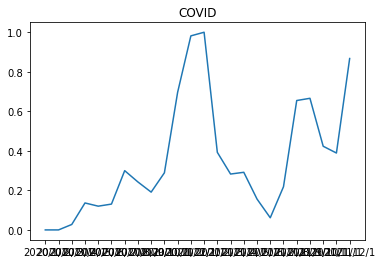

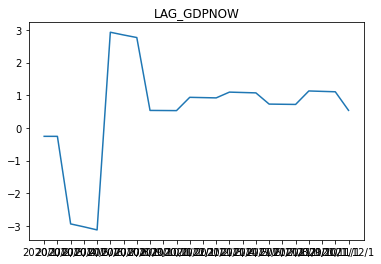

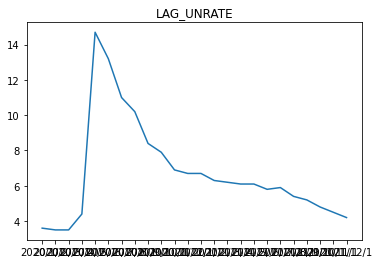

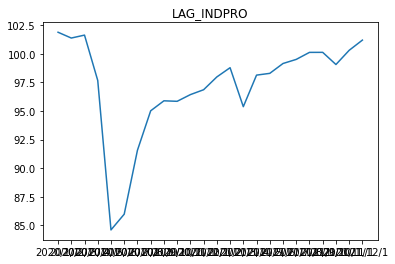

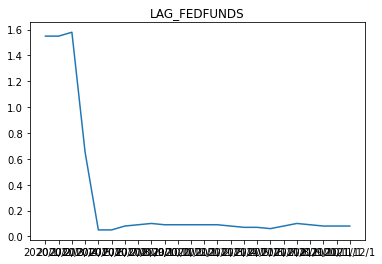

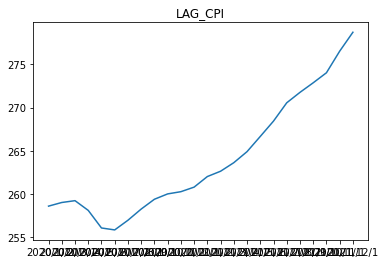

In [ ]:
import matplotlib.pyplot as plt

for col in df.columns[1:7]:
    plt.figure()
    plt.plot(df['DATE'], df[col]);
    plt.title(col)

In [ ]:
# Display the year when COVID new cases peaked.
df[df['COVID'] == df['COVID'].max()]['DATE'].values[0]

'2021/1/1'

In [ ]:
# Determine lagged EIs that peaked or bottomed out.
econ_peaks = ['LAG_GDPNOW', 'LAG_UNRATE']
econ_bottoms = ['LAG_GDPNOW', 'LAG_INDPRO', 'LAG_FEDFUNDS', 'LAG_CPI']

# Display the years when they peaked or bottomed out.
print('Indicators that peaked:')
for col in econ_peaks:
    arg = df[df[col] == df[col].max()]['DATE'].values[0][:-2]
    print(col, '\t', arg)

print('Indicators that bottomed up:')
for col in econ_bottoms:
    arg = df[df[col] == df[col].min()]['DATE'].values[0][:-2]
    print(col, '\t', arg)

Indicators that peaked:
LAG_GDPNOW 	 2020/6
LAG_UNRATE 	 2020/5
Indicators that bottomed up:
LAG_GDPNOW 	 2020/5
LAG_INDPRO 	 2020/5
LAG_FEDFUNDS 	 2020/5
LAG_CPI 	 2020/6


<Figure size 432x288 with 0 Axes>

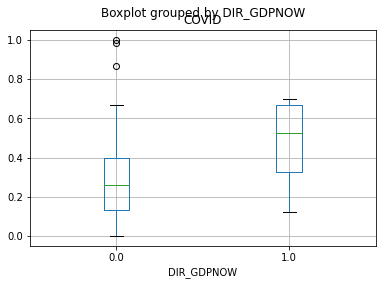

<Figure size 432x288 with 0 Axes>

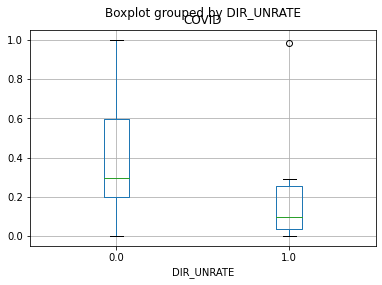

<Figure size 432x288 with 0 Axes>

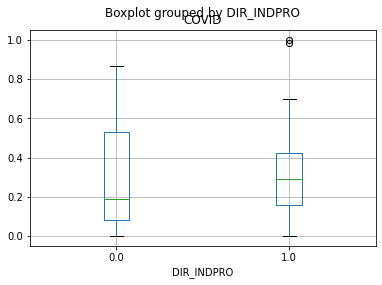

<Figure size 432x288 with 0 Axes>

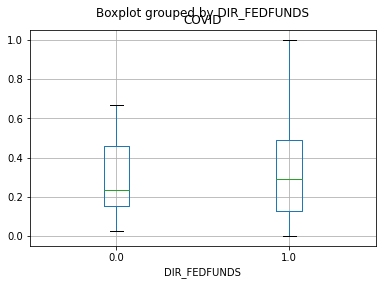

<Figure size 432x288 with 0 Axes>

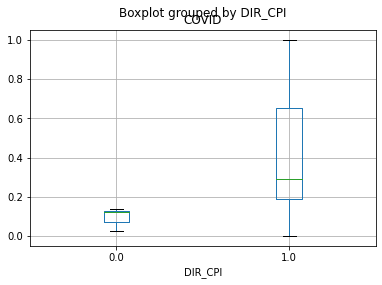

In [ ]:
for col in df.columns[7:]:
    plt.figure()
    df.boxplot(column = 'COVID', by = col);

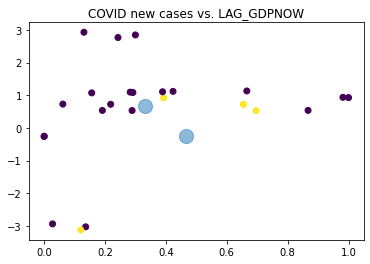

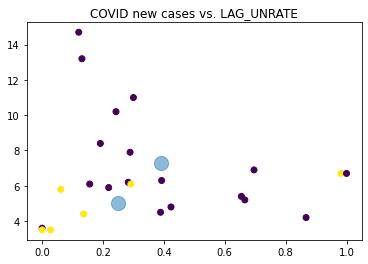

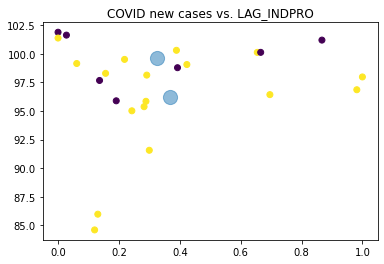

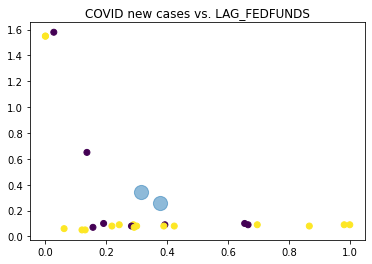

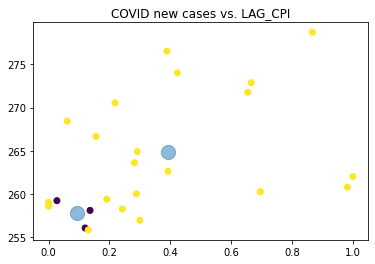

In [ ]:
for i in range(len(y[0])):
    j = i + 2 # lag
    k = i + 7 # direction
    
    sec = df.iloc[:, [1, j, k]]

    cov = sec.iloc[:, 0]
    lag = sec.iloc[:, 1]
    dir = sec.iloc[:, 2]
    
    hor = [sec[dir == b][cov.name].mean() for b in dir.unique()]
    ver = [sec[dir == b][lag.name].mean() for b in dir.unique()]

    plt.figure()
    plt.scatter(cov, lag, c = dir);
    plt.scatter(hor, ver, s = 200, alpha = 0.5);
    plt.title(cov.name + ' new cases vs. ' + lag.name)

## 6. Conclusion #
These classification models predict whether each economic indicator (EI) rises (1) or falls (0) direction with its lagged value and COVID new cases. Model 1 predicts GDP growth. It can correctly identify 80% of GDP deceleration but is unable to precisely recognize any GDP acceleration. Model 2 predicts unemployment rate. It can perfectly identify all unemployment increases, with moderate specificity and low precision, however. Model 3 predicts Industrial Production Index (IPI). It can correctly forecast 75% of IPI rises with moderate precision at 0.6, but no IPI fall is predicted. Model 4 predicts Federal Funds Rate (FFR). It can correctly recognize 80% of FFR rises Industrial Productionwith high precision, but not for FFR falls. Model 5 predicts Consumer Price Index (CPI). It can perfectly identify all CPI rises with the highest precision, whereas no detection for CPI falls.

Having analyzed the limitations, we infer that dramatic changes in every lagged EI during the 2nd quarter of 2020 disturb the performance of our models. Model 1 has zero precision as its test data has only one positive label predicted as false negative. Model 2 has low presision of 0.333 since it's affected by the steep peak in unemployment, after which the rate fell gradually and converged to pre-COVID levels. Also, it's difficult to split the data into clusters although we've classified it.

Unlike most stereotypes, the USA's COVID new cases over the time frame of our study fluctuated rather than a stably high level, and the number peaked in 2020/05. Nevertheless, only the beginning of COVID severely affected the economic indicators. Later, because the people adapted to the situation, GDP growth began to stablize at 1%, unemployment rate began to decline, and industrial production began to recover. However, FFR has kept lower than 0.2% and CPI has risen rapidly due to the Fed's policies in response to COVID. We predict that the interest rate would stay low and the inflation rate will increase, escalating the inflation in America.